# Исследование информации с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ)

In [4]:
import pandas as pd
import sklearn as skl
import folium as fl
from folium import plugins
from folium.plugins import FastMarkerCluster
import numpy as np

In [209]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (8, 6)

In [6]:
votes = pd.read_excel('geo_comment.xlsx')

In [7]:
votes.head()

x          y  comment_class  multiplier  \
0  37.612416  55.777454             -1           1   
1  37.612416  55.777454             -1           1   
2  37.603298  55.742108             -1           1   
3  37.558526  55.728758             -1           1   
4  37.566431  55.731794             -1           1   

                                             comment  
0  Во все разделы правил землепользования и застр...  
1  На основании вступившего в законную силу судеб...  
2  Внести в Проект правил землепользования и заст...  
3  Учитывая социальную значимость проекта строите...  
4  Учитывая социальную значимость проекта строите...

Исследуем данные

In [8]:
votes.describe()

x             y  comment_class    multiplier
count  70382.000000  70382.000000   70382.000000  70382.000000
mean      37.588417     55.786013      -0.663835      1.545935
std        0.138217      0.066225       0.747885     16.986786
min       37.148813     55.496939      -1.000000      1.000000
25%       37.445608     55.743558      -1.000000      1.000000
50%       37.570887     55.792331      -1.000000      1.000000
75%       37.702822     55.848665      -1.000000      1.000000
max       37.931228     55.994174       1.000000   1500.000000

In [9]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


Есть строки-дубликаты, в ds не отбрасываем, жители использовали одинаковый вид обращения.

In [328]:
votes[votes.duplicated() == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105863 entries, 1 to 108805
Data columns (total 3 columns):
x                105863 non-null float64
y                105863 non-null float64
comment_class    105863 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.2 MB


Для географических данных собираем данные только о координатах, голоса не важны.
Задача, решаемая таким образом: можно ли поделить город на районы, если известны только локации жителей.

In [10]:
X = votes[['y','x']]
X = X.drop_duplicates().reset_index()

In [11]:
del X['index']
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 2 columns):
y    2542 non-null float64
x    2542 non-null float64
dtypes: float64(2)
memory usage: 39.8 KB


y          x
0  55.777454  37.612416
1  55.742108  37.603298
2  55.728758  37.558526
3  55.731794  37.566431
4  55.723399  37.558957

In [13]:
# функция расчета суммы расстояний до центроида кластера. Написала потому, что не обратила внимание, что есть inertia_ 
# заодно сравнила с готовым методом)))
# cl_cntr - матрица координат центроидов
# k - вектор принадлежности кластеру
# X - матрица объектов
# возвращает словарь с номером кластера и расстоянием до него

def cl_dist(cl_cntr, k, X):
    cl_dict = {}
    cl_dict.clear()
    r = 0.0
    sum_dist = 0.0
    
    for i in range(len(k)): 
        r = (cl_cntr[k[i],0]-X['y'][i])**2 + (cl_cntr[k[i],1]-X['x'][i])**2
        cl_dict[ k[i]] = cl_dict.get(k[i],0) + r
    for key in cl_dict.keys():
        sum_dist += cl_dict[key]
    return sum_dist
    

# п.1 KMeans кластеризация

In [14]:
from sklearn.cluster import KMeans

In [15]:
# объекты кластеризации X

Ищем наилучшее число кластеров

* начинем с 4-х кластеров, тк меньшее в нашей задаче бессмысленно
* 16 - чтобы лучше увидеть перегиб кривой, при определении наилучшего разбиения

In [26]:
dist_lst = []
inertia_lst = []

for i in range(4, 17):
    model_km = KMeans( n_clusters = i , init = 'k-means++' )
    km_pred = model_km.fit_predict(X)
    cl_cntr = model_km.cluster_centers_
    cl_label = model_km.labels_
    sum_dist = cl_dist(cl_cntr, cl_label, X)
    #print('i', i , ',sum_dist ', sum_dist)
    dist_lst.append(sum_dist)
    inertia_lst.append(model_km.inertia_)

In [27]:
inertia_lst

[12.86995240856473,
 10.761604773985791,
 9.0608068470782221,
 7.8514120149773658,
 6.769323277696957,
 6.0156635916546266,
 5.3201917540938872,
 4.8839115279111631,
 4.5151140851584639,
 4.1584434502141692,
 3.7901110811266525,
 3.4870901078509298,
 3.2466708479345963]

In [28]:
dist_lst # собственная функция считает очень точно

[12.869952408564735,
 10.761604773985793,
 9.0608068470782221,
 7.8514120149773641,
 6.7693232776969561,
 6.0156635916546275,
 5.320191754093889,
 4.883911527911164,
 4.5151140851584639,
 4.1584434502141692,
 3.790111081126653,
 3.4870901078509302,
 3.2466708479345963]

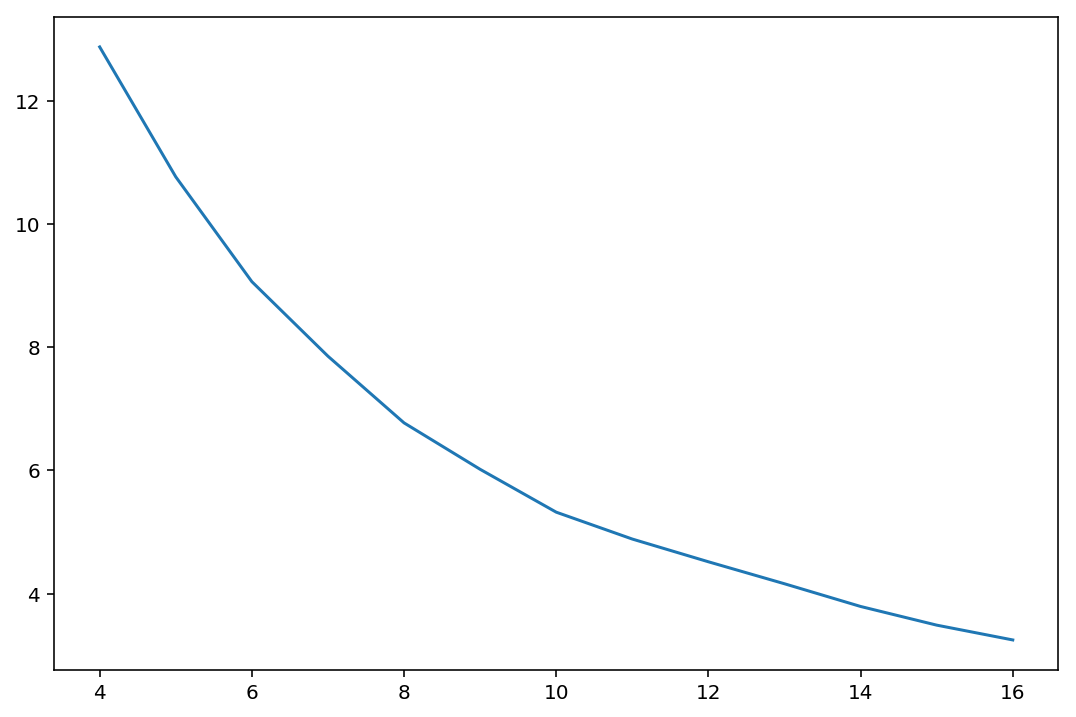

In [165]:
km = range(4,17)
plt.plot( km , inertia_lst)

In [166]:
diff = np.diff(inertia_lst)

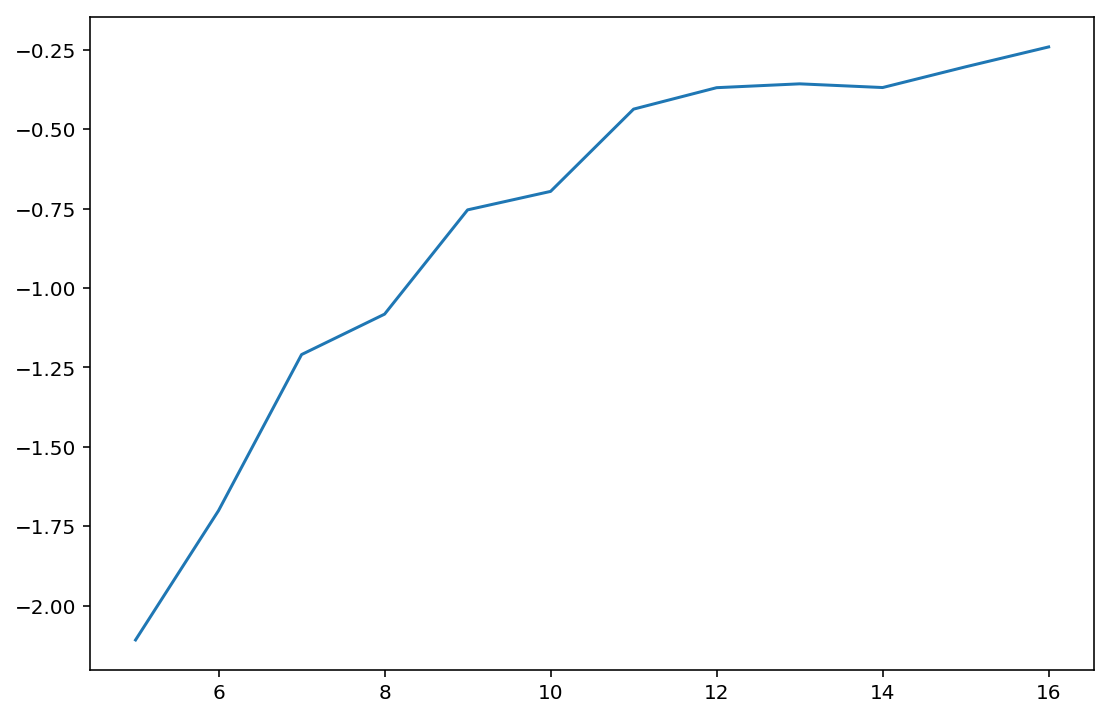

In [167]:
plt.plot(km[1:], diff)

In [168]:
diff_r = diff[1:] / diff[:-1]

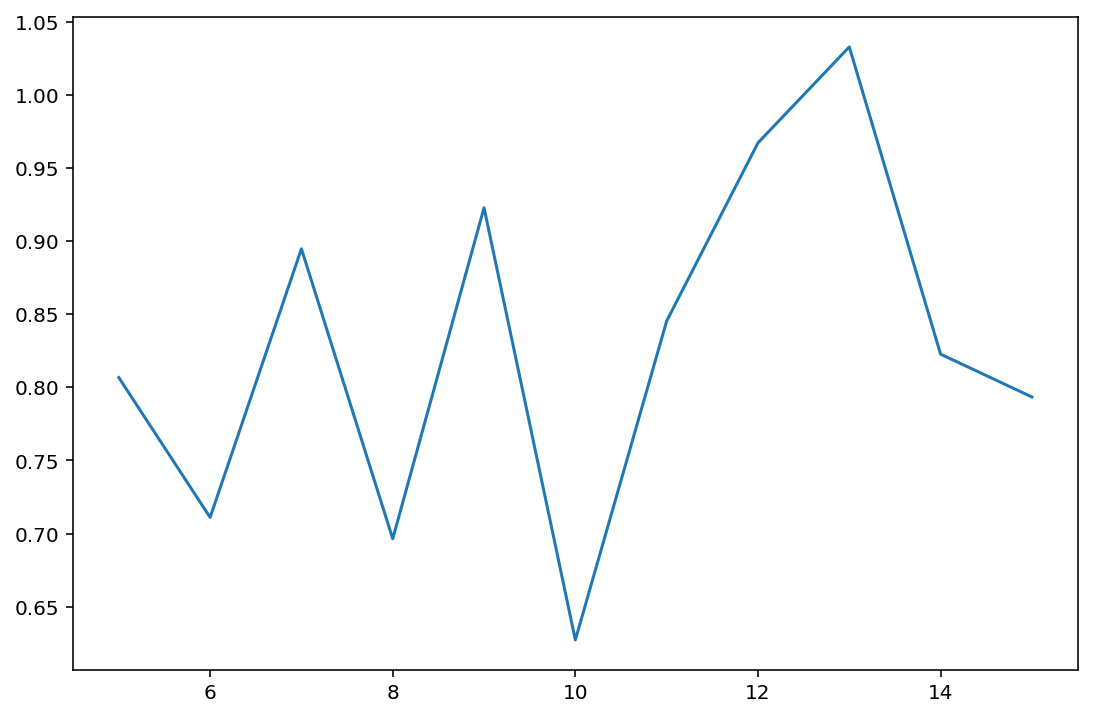

In [169]:
plt.plot(km[1:-1], diff_r)

In [170]:
k_opt = km[np.argmin(diff_r)+1]
k_opt

10

Оптимальное число кластеров - 10. Посмотрим на разбиение на районы на обычном графике scatter plot.

Для отображения на карте москвы используем библиотеку folium. Для этого данные нужно немного подготовить

In [35]:
#Делаем предсказание для 10-ти кластеров и получаем данные для разбиения.

In [36]:
model_km = KMeans( n_clusters = 10 , init = 'k-means++' )
km_pred = model_km.fit_predict(X)
cl_cntr = model_km.cluster_centers_
cl_label = model_km.labels_

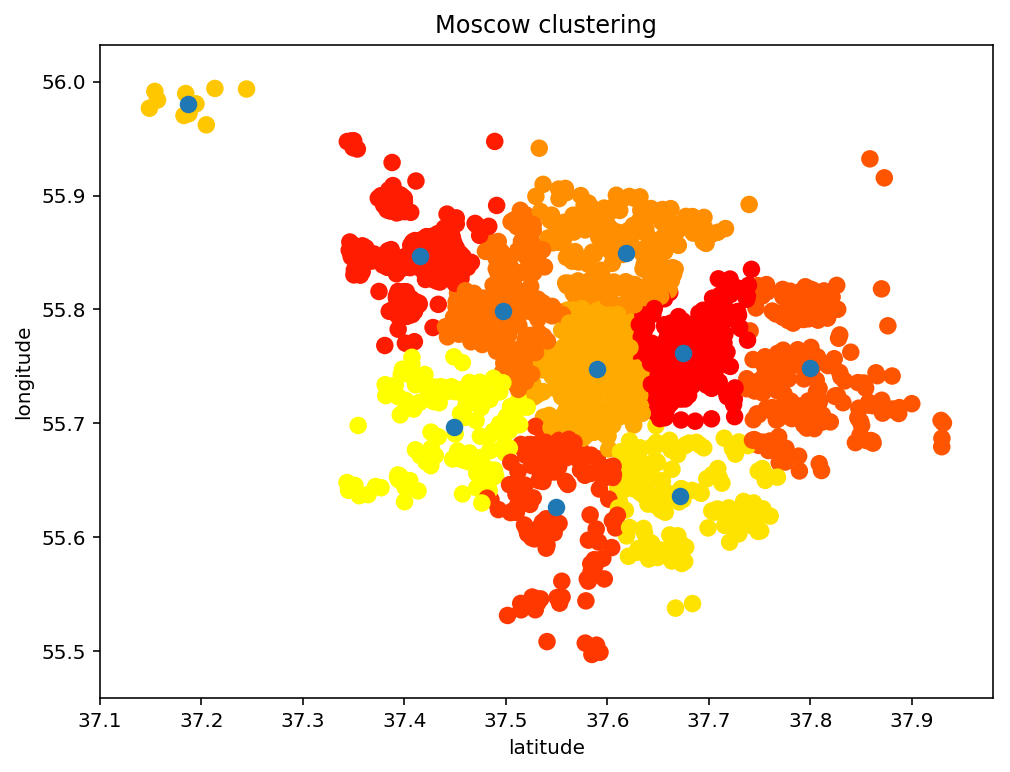

In [255]:
plt.scatter(X['x'], X['y'], c = cl_label, cmap='autumn', s = 60)
plt.scatter(cl_cntr[:,1], cl_cntr[:,0], s =60)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Moscow clustering')
#plt.scatter(cl_cntr[:,0], cl_cntr[:,1])

In [38]:
# инициализация карты Москвыа

In [39]:
map_mos = fl.Map(location=[55.75, 37.615], zoom_start=9)
map_mos_cl = fl.Map(location=[55.75, 37.615], zoom_start=9)

У библиотеки есть встроенный инструмент кластеризации, посмотрим, как он обработает наши данные

In [40]:
fl_cluster = X.values.tolist()
FastMarkerCluster(data=fl_cluster).add_to(map_mos)

In [41]:
map_mos
# при наведении на точку показывает границы кластера

In [42]:
map_mos.save("folium_pzz_moscow_clusters.html")

In [43]:
label = pd.DataFrame(data = cl_label, columns= ['cluster'])
X_fl = pd.concat([X, label], axis=1)

In [44]:
X_fl.head()

y          x  cluster
0  55.777454  37.612416        6
1  55.742108  37.603298        6
2  55.728758  37.558526        6
3  55.731794  37.566431        6
4  55.723399  37.558957        6

Из полученного df выделим координаты отдельных кластеров

In [45]:
cl_fl = []
for i in range(0, 10):
    cl_fl.append(X_fl[['y','x']][X_fl.cluster == i].values.tolist())

In [46]:
# проверка, что все ок!

sumfl =0 
for i in range(0, 10): 
    sumfl += len(cl_fl[i])
sumfl

2542

In [47]:
m_color = ['red','blue','green','yellow','brown','orange','magenta', 'gray','black','pink']

In [48]:
for i in range(0, 10):
    for j in range(len(cl_fl[i])):
        fl.CircleMarker(cl_fl[i][j],radius = 5, color = m_color[i], fill = True,  fill_color = m_color[i], \
                fill_opacity = 0.6).add_to(map_mos_cl)

In [49]:
map_mos_cl

In [50]:
#сохраняем
map_mos_cl.save("pzz_moscow_clusters.html")

# п.2 Кластеризация по типу голоса за/против

Работаем с данными, принимая во внимание, что нас интересуют голоса за/против.

При такой постановке задачи на карте города выделим кластеры жителей, которые голосуют "за"; кластеры жителей, голосующих "против". При такой кластеризации границы кластеров могут не совпасть с географическими.

In [99]:
df = pd.read_excel('geo.xlsx')

In [108]:
#выбираем голоса за (1)
X_yes = df[['y','x']][df.comment_class == 1]

In [109]:
#X_yes = X_yes.drop_duplicates()

In [110]:
X_yes.reset_index(inplace = True)

In [111]:
del X_yes['index']
X_yes.head()

y          x
0  55.741982  37.588916
1  55.734273  37.589311
2  55.728758  37.558526
3  55.731794  37.566431
4  55.734273  37.589311

In [112]:
X_yes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13659 entries, 0 to 13658
Data columns (total 2 columns):
y    13659 non-null float64
x    13659 non-null float64
dtypes: float64(2)
memory usage: 213.5 KB


In [55]:
#выбираем голоса против (-1)

In [113]:
X_no = df[['y','x']][df.comment_class == -1]

In [114]:
#X_no = X_no.drop_duplicates()

In [115]:
X_no.reset_index(inplace = True)

In [116]:
del X_no['index']
X_no.info()
X_no.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95147 entries, 0 to 95146
Data columns (total 2 columns):
y    95147 non-null float64
x    95147 non-null float64
dtypes: float64(2)
memory usage: 1.5 MB


y          x
0  55.777454  37.612416
1  55.777454  37.612416
2  55.742108  37.603298
3  55.728758  37.558526
4  55.731794  37.566431

Отобразим на карте, как распределены точки голосов за/пртоив, накладываясь друг на друга.

In [118]:
yes_no = fl.Map(location=[55.75, 37.615], zoom_start=9)

In [119]:
X_yes_fl = X_yes.drop_duplicates().values.tolist()

In [120]:
X_no_fl = X_no.drop_duplicates().values.tolist()

In [121]:
for i in range(len(X_no_fl)):
    fl.CircleMarker(X_no_fl[i],radius = 6, color = 'red', fill = True,  fill_color = 'red', \
                fill_opacity = 0.4).add_to(yes_no)

for i in range(len(X_yes_fl)):
    fl.CircleMarker(X_yes_fl[i],radius = 6, color = 'green', fill = True,  fill_color = 'green', \
                fill_opacity = 0.4).add_to(yes_no)

In [122]:
yes_no

In [123]:
#сохраняем
yes_no.save("pzz_moscow_yes_no.html")

Кластеризуем голоса "за"

In [124]:
inertia_yes = []
for i in range(2, 18):
    model_km_yes = KMeans( n_clusters = i , init = 'k-means++' )
    km_pred_yes = model_km_yes.fit_predict(X_yes)
    inertia_yes.append(model_km_yes.inertia_)

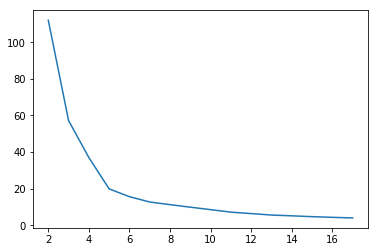

In [132]:
km_yes = range(2,18)
plt.plot( km_yes , inertia_yes)

In [133]:
diff_yes = np.diff(inertia_yes)

In [142]:
diff_r = diff_yes[1:] / diff_yes[:-1]

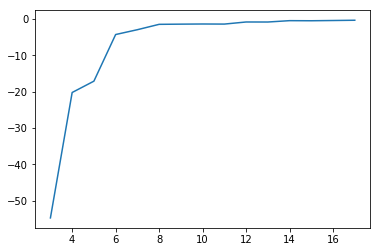

In [143]:
plt.plot(km_yes[1:], diff_yes)

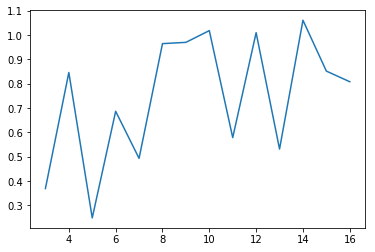

In [144]:
plt.plot(km_yes[1:-1], diff_r)

In [146]:
k_opt = km_yes[np.argmin(diff_r)+1]
k_opt

5

In [148]:
#оптимальное число кластеров 5

model_km_yes = KMeans( n_clusters = 5 , init = 'k-means++' )
km_pred_yes = model_km_yes.fit_predict(X_yes)

In [149]:
cl_cntr_yes = model_km_yes.cluster_centers_
cl_label_yes = model_km_yes.labels_

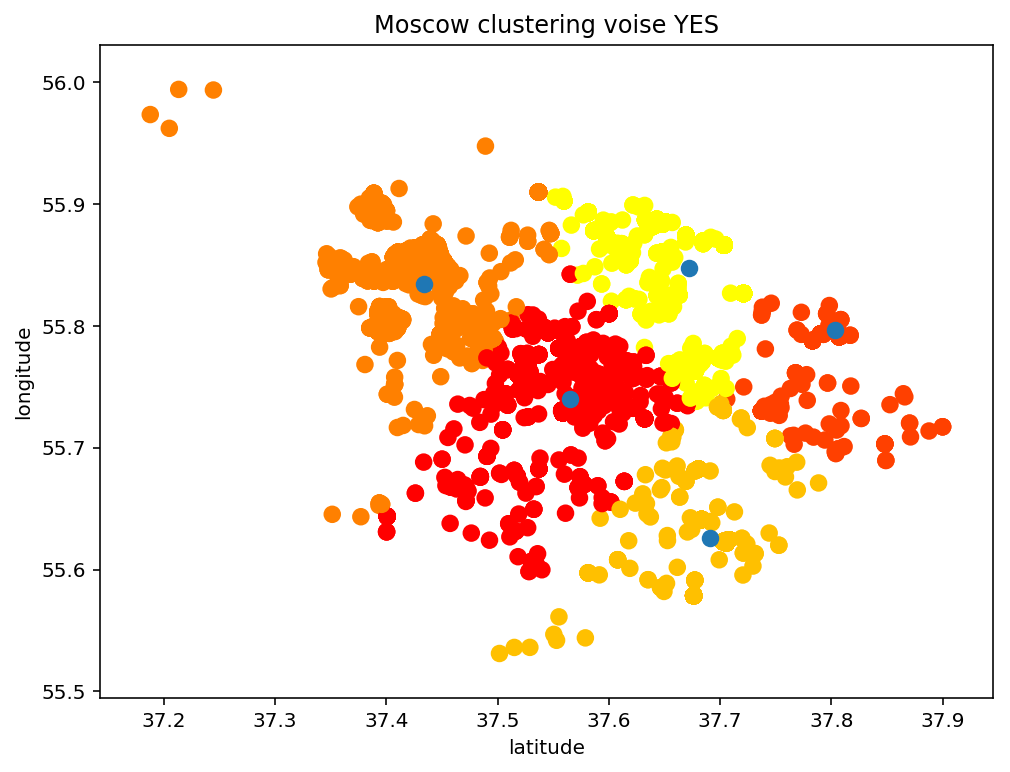

In [254]:
plt.scatter(X_yes['x'], X_yes['y'], cmap = 'autumn', c = cl_label_yes, s = 60)
plt.scatter(cl_cntr_yes[:,1], cl_cntr_yes[:,0], s =60)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Moscow clustering voise YES')

Отобразим кластеры голосов "за" на карте Москвы

In [201]:
mos_yes = fl.Map(location=[55.75, 37.615], zoom_start=9)

In [186]:
label_yes = pd.DataFrame(data = cl_label_yes, columns= ['cluster'])
X_fl_yes = pd.concat([X_yes, label_yes], axis=1)

In [187]:
X_fl_yes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13659 entries, 0 to 13658
Data columns (total 3 columns):
y          13659 non-null float64
x          13659 non-null float64
cluster    13659 non-null int32
dtypes: float64(2), int32(1)
memory usage: 266.9 KB


Уменьшим df для быстрой отрисовки.

In [191]:
X_fl_y = X_fl_yes.drop_duplicates()

In [194]:
X_fl_y.reset_index(inplace = True)

In [197]:
del X_fl_y['index']

In [199]:
cl_yes = []
for i in range(0, 5):
    cl_yes.append(X_fl_y[['y','x']][X_fl_y.cluster == i].values.tolist())

In [200]:
m_color = ['red','blue','green','yellow','orange']

In [203]:
for i in range(0, 5):
    for j in range(len(cl_yes[i])):
        fl.CircleMarker(cl_yes[i][j],radius = 5, color = m_color[i], fill = True,  fill_color = m_color[i], \
                fill_opacity = 0.6).add_to(mos_yes)

In [204]:
mos_yes

In [289]:
#сохраняем
yes_no.save("pzz_moscow_yes.html")

Кластеризация жителей, проголосовавших "против"

In [237]:
inertia_no = []
for i in range(2, 19):
    model_km_no = KMeans( n_clusters = i , init = 'k-means++' )
    km_pred_no = model_km_no.fit_predict(X_no)
    inertia_no.append(model_km_no.inertia_)

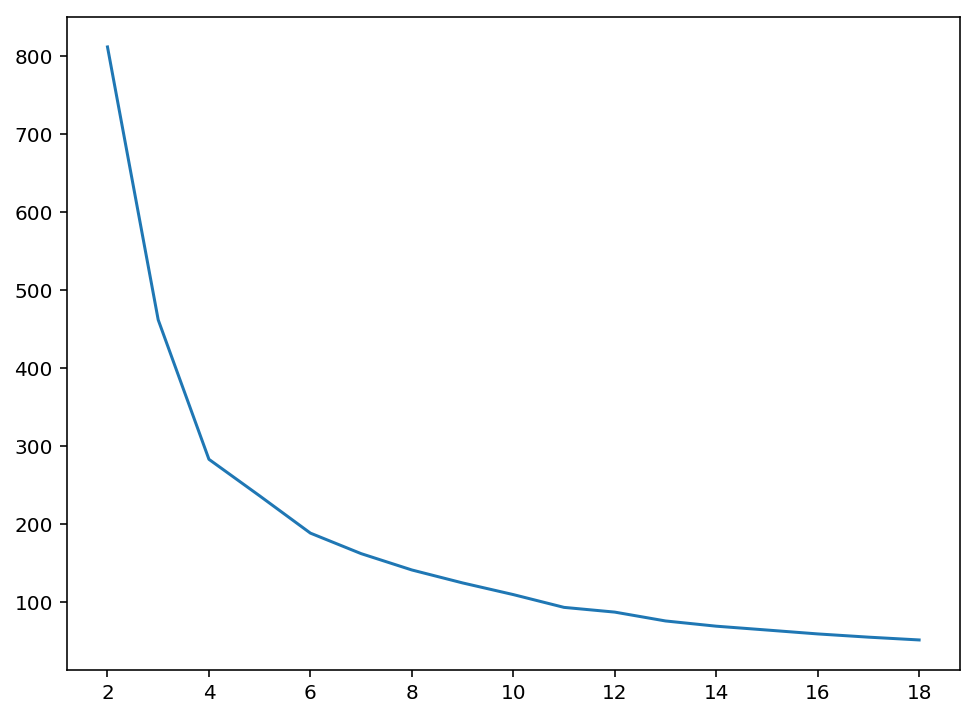

In [238]:
km_no = range(2,19)
plt.plot( km_no , inertia_no)

In [244]:
diff_no = np.diff(inertia_no)

In [245]:
diff_r = diff_no[1:] / diff_no[:-1]

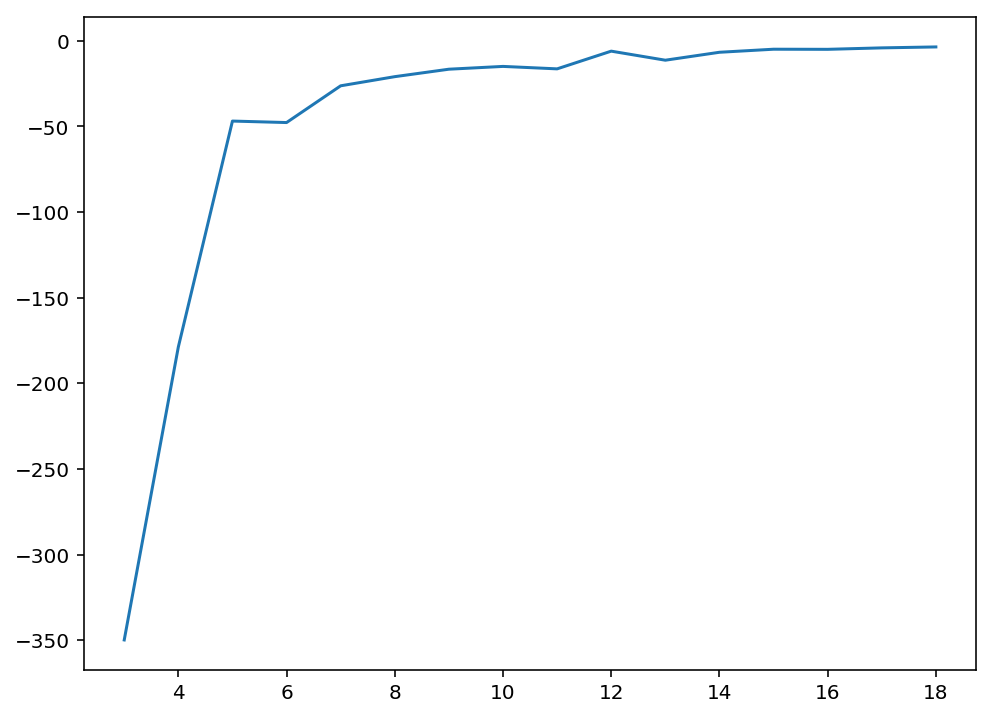

In [246]:
plt.plot(km_no[1:], diff_no)

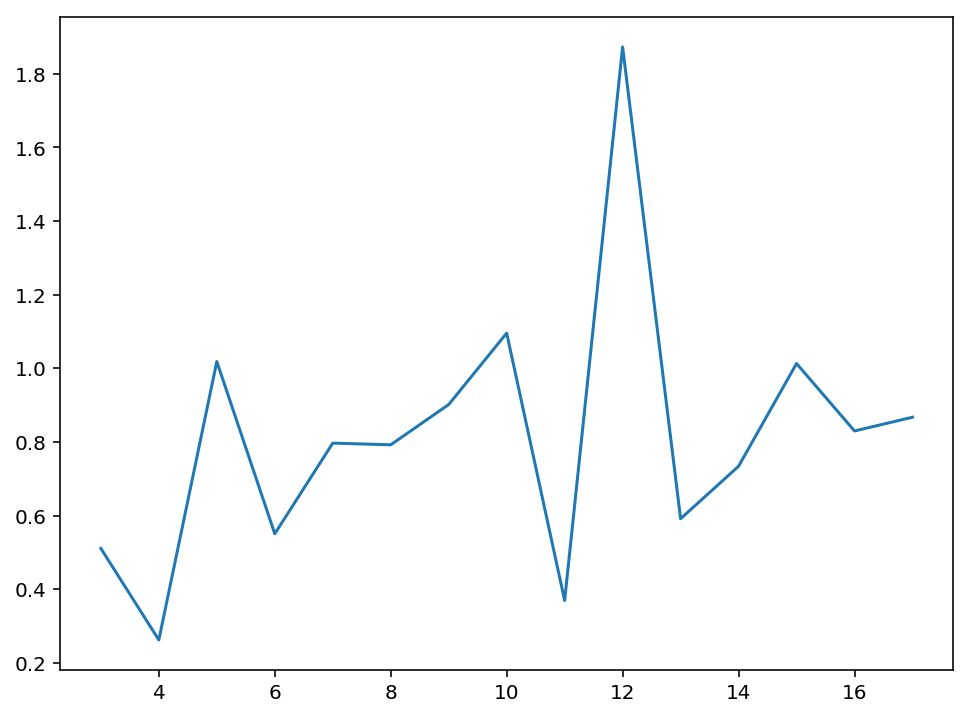

In [247]:
plt.plot(km_no[1:-1], diff_r)

In [243]:
k_opt = km_no[np.argmin(diff_r)+1]
k_opt

4

На мой взгляд 4 кластера мало, поэтому при анализе графика отношений разностей суммарных расстояний остановилась
на 8-ми кластерах, так как данных с голосами "против" более 90 тыс, есть очень активные районы. В этом месте кривая становится пологой.

In [304]:
model_km_no = KMeans( n_clusters = 11 , init = 'k-means++' )
km_pred_no = model_km_no.fit_predict(X_no)

In [305]:
cl_cntr_no = model_km_no.cluster_centers_
cl_label_no = model_km_no.labels_

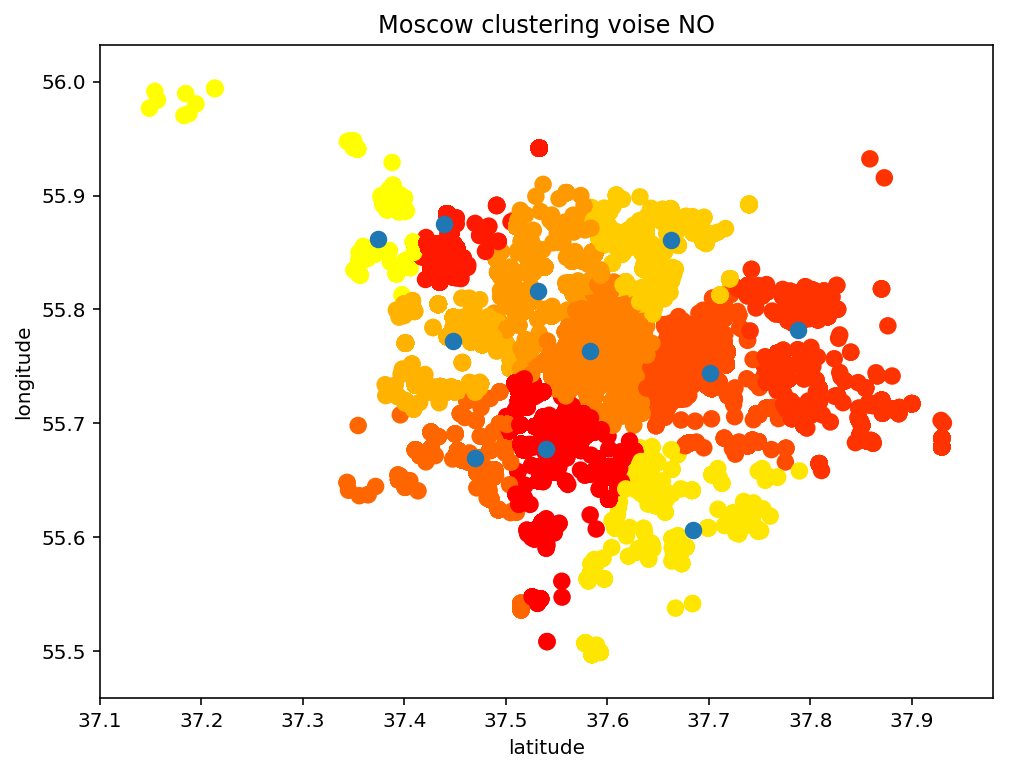

In [306]:
plt.scatter(X_no['x'], X_no['y'], cmap = 'autumn', c = cl_label_no, s = 60)
plt.scatter(cl_cntr_no[:,1], cl_cntr_no[:,0], s =60)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Moscow clustering voise NO')

наложим полученные данные на карту

In [330]:
mos_no = fl.Map(location=[55.75, 37.615], zoom_start=10)

In [308]:
label_no = pd.DataFrame(data = cl_label_no, columns= ['cluster'])
X_fl_no = pd.concat([X_no, label_no], axis=1)

In [309]:
X_fl_no.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95147 entries, 0 to 95146
Data columns (total 3 columns):
y          95147 non-null float64
x          95147 non-null float64
cluster    95147 non-null int32
dtypes: float64(2), int32(1)
memory usage: 1.8 MB


Уменьшим для быстрой отрисовки

In [310]:
X_fl_n = X_fl_no.drop_duplicates()

In [311]:
X_fl_n.reset_index(inplace = True)

In [312]:
del X_fl_n['index']

In [313]:
X_fl_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 3 columns):
y          1749 non-null float64
x          1749 non-null float64
cluster    1749 non-null int32
dtypes: float64(2), int32(1)
memory usage: 34.2 KB


In [325]:
cl_no = []
for i in range(0, 11):
    cl_no.append(X_fl_n[['y','x']][X_fl_n.cluster == i].values.tolist())

In [331]:
m_color = ['red','blue','green','yellow','brown','orange','magenta', 'gray','black','pink','cyan']

In [332]:
for i in range(0, 11):
    for j in range(len(cl_no[i])):
        fl.CircleMarker(cl_no[i][j],radius = 5, color = m_color[i], fill = True,  fill_color = m_color[i], \
                fill_opacity = 0.6).add_to(mos_no)

In [333]:
mos_no

In [329]:
#сохраняем
yes_no.save("pzz_moscow_no.html")